## Creating a Model

In [1]:
import pandas as pd

df = pd.read_parquet("../0 - Data/scaled_transactions.pq")
df.head()

,Amount,MCC,Has Chip,Cards Issued,Credit Limit,Year PIN last Changed,Current Age,Retirement Age,Birth Year,Birth Month,...,Card Brand_Visa,Card Type_Debit,Card Type_Debit (Prepaid),Gender_Male,Age Group_26-35,Age Group_36-45,Age Group_46-60,Age Group_60+,Use Chip_Online Transaction,Use Chip_Swipe Transaction
0,130.95,5912,1,2,24295.0,2008,53,66,1966,11,...,True,True,False,False,False,False,True,False,False,False
1,130.95,5912,1,2,21968.0,2014,53,66,1966,11,...,True,True,False,False,False,False,True,False,False,False
2,130.95,5912,1,2,46414.0,2004,53,66,1966,11,...,True,True,False,False,False,False,True,False,False,False
3,130.95,5912,0,1,12400.0,2012,53,66,1966,11,...,True,False,False,False,False,False,True,False,False,False
4,130.95,5912,1,1,28.0,2009,53,66,1966,11,...,False,False,True,False,False,False,True,False,False,False


#### Split the data into training and test

In [2]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

split_date = '2019-10-01 00:00:00'

train_data = df[df['Datetime'] < split_date]
test_data = df[df['Datetime'] >= split_date]

#### Drop the Datetime Column

In [3]:
train_data = train_data.drop(["Datetime"], axis=1)
test_data = test_data.drop(["Datetime"], axis=1)

#### Create X and y Vectors

In [4]:
target_column = 'Is Fraud'

# Separate features and target for the training set
X_train = train_data.drop(target_column, axis=1)
y_train = train_data[target_column]

# Separate features and target for the test set
X_test = test_data.drop(target_column, axis=1)
y_test = test_data[target_column]

#### Train the Model

In [5]:
import xgboost as xgb

# Convert your dataset to DMatrix, XGBoost's internal data structure
dtrain = xgb.DMatrix(X_train, label=y_train)

# Set parameters for Random Forest using GPU
params = {
    'objective': 'binary:logistic',     # Adjust for your task (e.g., classification or regression)
    'tree_method': 'hist',              # Use histogram-based algorithm
    'max_depth': 6,                     # Depth of trees
    'device': 'cuda'                    # Select the GPU
}

# Train the Random Forest using XGBoost in RF mode
model = xgb.train(params, dtrain, num_boost_round=100)

#### Convert the Test Data into DMatrix for XGBoost

In [8]:
# Convert the test set to DMatrix
dtest = xgb.DMatrix(X_test)

# Make probability predictions
y_pred_proba = model.predict(dtest)

# Convert probabilities to binary predictions (0 or 1) based on a threshold, usually 0.5
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba]

#### Test the Predictions

In [9]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9994727879638502


In [10]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2671415
           1       0.14      0.05      0.07      1134

    accuracy                           1.00   2672549
   macro avg       0.57      0.52      0.54   2672549
weighted avg       1.00      1.00      1.00   2672549



In [11]:
from sklearn.metrics import roc_auc_score

# Calculate the ROC-AUC score using the probability predictions
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9387279200576648


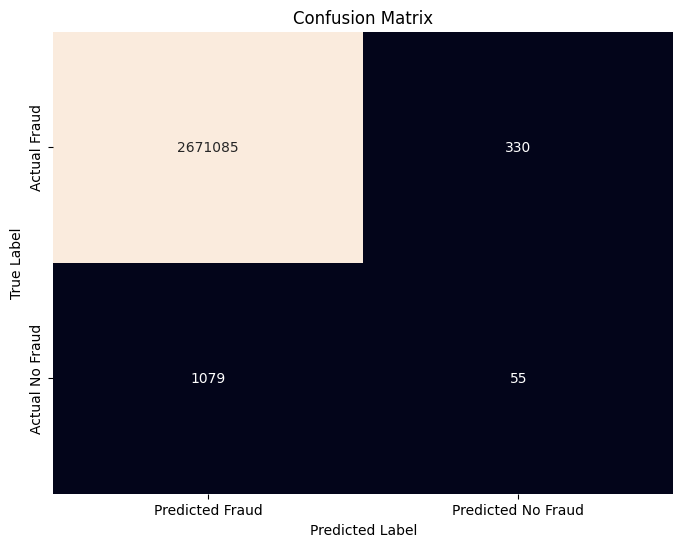

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['Actual Fraud', 'Actual No Fraud'], columns=['Predicted Fraud', 'Predicted No Fraud'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Evaluation

I’ve developed a Random Forest model that achieved an impressive accuracy of 99.95%, primarily due to its strong performance on the majority class (non-fraud). However, the model struggles significantly with detecting fraudulent transactions, as indicated by the low precision (0.14) and recall (0.05) for the fraud class. This discrepancy suggests that the model is biased towards predicting the majority class, which is a common issue in imbalanced datasets.

The high ROC-AUC score of 0.94 indicates good overall discrimination ability, but the real challenge lies in improving the detection of the minority class.